In [2]:
# Import.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris, load_wine
import importlib
rf = importlib.import_module("random-forests")

# Load datasets.
X_iris, y_iris = load_iris(return_X_y=True)  # feature_type="continuous"
X_wine, y_wine = load_wine(return_X_y=True)  # feature_type="continuous"
mushroom = np.genfromtxt("agaricus-lepiota.data", delimiter=",", dtype=str)
X_mushroom = mushroom[:, 1:]  # feature_type="categorical"
y_mushroom = mushroom[:, 0]
breast_cancer = np.genfromtxt("breast-cancer.data", delimiter=",", dtype=str)
breast_cancer = breast_cancer[(breast_cancer != "?").all(axis=1), :]
X_breast_cancer = breast_cancer[:, 1:]  # feature_type="categorical"
y_breast_cancer = breast_cancer[:, 0]
heart_disease = np.genfromtxt("processed.cleveland.data", delimiter=",")
heart_disease = heart_disease[~np.isnan(heart_disease).any(axis=1), :]
X_heart_disease = heart_disease[:, :13]  # feature_type="categorical"
y_heart_disease = heart_disease[:, 13]
y_heart_disease[np.where(y_heart_disease >= 1)] = 1
titanic = pd.read_csv("titanic.csv").drop(columns=["PassengerId", "Name", "Ticket", "Cabin"]).dropna()
X_titanic = titanic.loc[:, titanic.columns!="Survived"].to_numpy()  # feature_type: complex
y_titanic = titanic["Survived"].to_numpy()

In [3]:
# train_test_split(X, y) -> X_train, X_test, y_train, y_test
ftype_h_d = np.array([0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1])
feature_type_titanic = np.ones(7)
feature_type_titanic[2] = 0  # Age
feature_type_titanic[5] = 0  # Fare
datasets = {
    "iris (continuous)": (*train_test_split(X_iris, y_iris, stratify=y_iris), "continuous"),
    "wine (continuous)": (*train_test_split(X_wine, y_wine, stratify=y_wine), "continuous"),
    # "mushroom (categorical)": (*train_test_split(X_mushroom, y_mushroom, stratify=y_mushroom), "categorical"),
    "breast_cancer (categorical)": (*train_test_split(X_breast_cancer, y_breast_cancer, stratify=y_breast_cancer), "categorical"),
    "titanic (complex)": (*train_test_split(X_titanic, y_titanic, stratify=y_titanic), feature_type_titanic),
    "heart_disease (complex)": (*train_test_split(X_heart_disease, y_heart_disease, stratify=y_heart_disease), ftype_h_d),
}
cmap = {"iris (continuous)": "blue", "wine (continuous)": "purple", "heart_disease (complex)": "red", "breast_cancer (categorical)": "orange", "titanic (complex)": "green"}

**Breiman**
- RF accuracy depends on individual tree **strength** and **correlation**
- **LLN** guarantees the generalisation error converges a.s. as `n_trees` increases,<br>
  so that overfitting is not a problem

In [3]:
# Test varying `n_trees`.
n_trees = np.arange(1, 51)
n_exp=5  # Number of experiments.
error_rates_mean = np.ones((len(datasets.keys()), len(n_trees)))
error_rates_std = np.zeros((len(datasets.keys()), len(n_trees)))
for dataset_idx, dataset in enumerate(datasets.keys()):
    X_train, X_test, y_train, y_test, feature_type= datasets[dataset]
    n_features = X_train.shape[1]
    n_c = int(n_features / 2) + 1
    # m = int(np.sqrt(len(np.unique(y_train))))
    for n in n_trees:
        random_forest = rf.RandomForest(
            n_trees=n, max_depth=100, min_leaf_size=1, n_candidates=n_c, criterion="gini")
        error_rate = np.ones(n_exp)
        for i in range(n_exp):
            random_forest.fit(X_train, y_train, feature_type, m_features=2)
            y_predicted = random_forest.predict(X_test)
            error_rate[i] = rf.random_forests.misclassification_rate(y_predicted, y_test)
        error_rates_mean[dataset_idx, n-1] = error_rate.mean()
        error_rates_std[dataset_idx, n-1] = error_rate.std()

np.savez("test_rf_n50.npz", mean=error_rates_mean, std=error_rates_std)

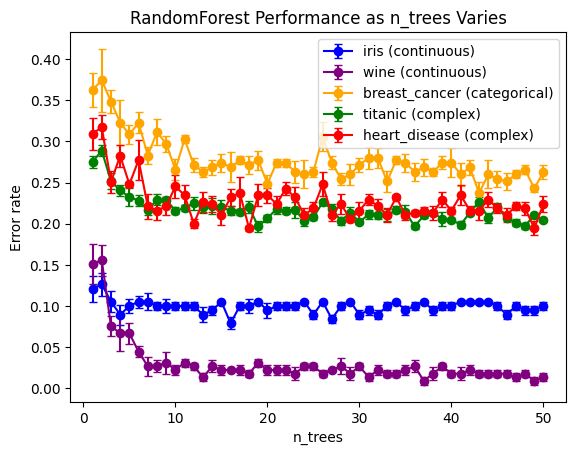

In [4]:
error_rates = np.load("test_rf_n50.npz")
error_rates_mean = error_rates["mean"]
error_rates_std = error_rates["std"]
n_trees = np.arange(1, 51)
n_exp=5
for dataset_idx, dataset in enumerate(datasets.keys()):
    plt.errorbar(n_trees, error_rates_mean[dataset_idx, :],
                 yerr=error_rates_std[dataset_idx, :]/np.sqrt(n_exp),
                 label=dataset, capsize=3, fmt="o-", color=cmap[dataset]
                 )
plt.xlabel("n_trees")
plt.ylabel("Error rate")
plt.title("RandomForest Performance as n_trees Varies")
plt.legend()

In [5]:
# Test varying `n_trees` using ImprovedRandomForest.
n_trees = np.arange(1, 21)
n_exp=5  # Number of experiments.
error_rates_mean = np.ones((len(datasets.keys()), len(n_trees)))
error_rates_std = np.zeros((len(datasets.keys()), len(n_trees)))
for dataset_idx, dataset in enumerate(datasets.keys()):
    X_train, X_test, y_train, y_test, feature_type= datasets[dataset]
    n_features = X_train.shape[1]
    n_c = int(np.sqrt(n_features))
    # m = int(np.sqrt(len(np.unique(y_train))))
    for n in n_trees:
        random_forest = rf.ImprovedRandomForest(
            n_trees=n, max_depth=100, min_leaf_size=1, n_candidates=n_c, criterion="gini")
        error_rate = np.ones(n_exp)
        for i in range(n_exp):
            random_forest.fit(X_train, y_train, feature_type, m_features=2)
            y_predicted = random_forest.predict(X_test)
            error_rate[i] = rf.random_forests.misclassification_rate(y_predicted, y_test)
        error_rates_mean[dataset_idx, n-1] = error_rate.mean()
        error_rates_std[dataset_idx, n-1] = error_rate.std()

np.savez("test_n_improved.npz", mean=error_rates_mean, std=error_rates_std)

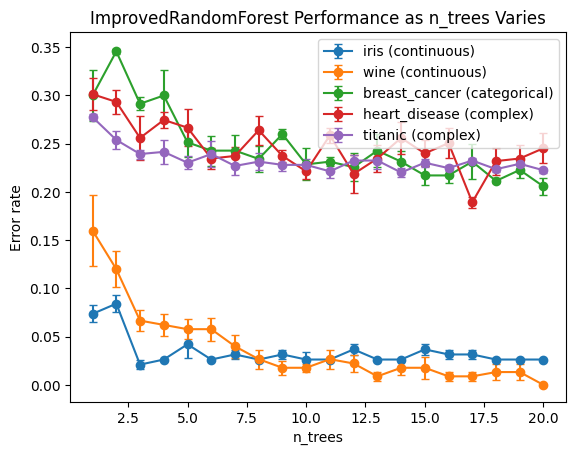

In [6]:
error_rates = np.load("test_n_improved.npz")
error_rates_mean = error_rates["mean"]
error_rates_std = error_rates["std"]
n_trees = np.arange(1, 21)
n_exp=5
for dataset_idx, dataset in enumerate(datasets.keys()):
    plt.errorbar(n_trees, error_rates_mean[dataset_idx, :],
                 yerr=error_rates_std[dataset_idx, :]/np.sqrt(n_exp),
                 label=dataset, capsize=3, fmt="o-"
                 )
plt.xlabel("n_trees")
plt.ylabel("Error rate")
plt.title("ImprovedRandomForest Performance as n_trees Varies")
plt.legend()

In [5]:
# Test varing `n_trees` with different `m_features` on the Titanic dataset.
X_train, X_test, y_train, y_test, feature_type= datasets["titanic (complex)"]
n_trees = np.arange(1, 51)
m_features = [1, 2, 3, 4]
n_exp=5
error_rates_mean = np.ones((len(m_features), len(n_trees)))
error_rates_std = np.zeros((len(m_features), len(n_trees)))
for n in n_trees:
    for m in m_features:
        random_forest = rf.RandomForest(
            n_trees=n, max_depth=100, min_leaf_size=1, n_candidates=4, criterion="gini")
        error_rate = np.ones(n_exp)
        for i in range(n_exp):
            random_forest.fit(X_train, y_train, feature_type, m_features=m)
            y_predicted = random_forest.predict(X_test)
            error_rate[i] = rf.random_forests.misclassification_rate(y_predicted, y_test)
        error_rates_mean[m_features.index(m), n-1] = error_rate.mean()
        error_rates_std[m_features.index(m), n-1] = error_rate.std()

np.savez("test_titanic_n50_m4.npz", mean=error_rates_mean, std=error_rates_std)

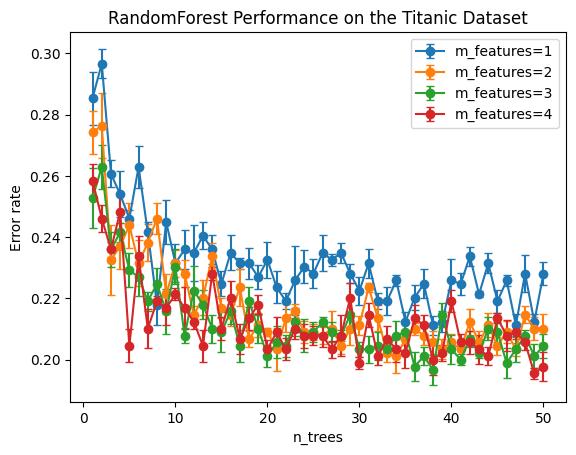

In [20]:
error_rates = np.load("test_titanic_n50_m4.npz")
error_rates_mean = error_rates["mean"]
error_rates_std = error_rates["std"]
n_trees = np.arange(1, 51)
m_features = [1, 2, 3, 4]
n_exp=3
for m in m_features:
    plt.errorbar(n_trees, error_rates_mean[m_features.index(m), :],
                 yerr=error_rates_std[m_features.index(m), :]/n_exp,
                 label=f"m_features={m}", capsize=3, fmt="o-"
                 )
    # plt.plot(n_trees, error_rates_mean[m_features.index(m), :],
    #          label=f"m_features={m}")
plt.xlabel("n_trees")
plt.ylabel("Error rate")
plt.title("RandomForest Performance on the Titanic Dataset")
plt.legend()

**Breiman**
- RF performance is *insensitive* to the number of features selected to split each node.
- Usually `m_features=1` or `m_features=2` gives near optimum results

In [9]:
# Test varing `n_trees` with different `m_features` on the Breast Cancer dataset.
X_train, X_test, y_train, y_test, feature_type= datasets["breast_cancer (categorical)"]
n_trees = np.arange(1, 31)
m_features = [1, 2, 3]
n_exp=3
error_rates_mean = np.ones((len(m_features), len(n_trees)))
error_rates_std = np.zeros((len(m_features), len(n_trees)))
for n in n_trees:
    for m in m_features:
        random_forest = rf.RandomForest(
            n_trees=n, max_depth=100, min_leaf_size=1, n_candidates=3, criterion="gini")
        error_rate = np.ones(n_exp)
        for i in range(n_exp):
            random_forest.fit(X_train, y_train, feature_type, m_features=m)
            y_predicted = random_forest.predict(X_test)
            error_rate[i] = rf.random_forests.misclassification_rate(y_predicted, y_test)
        error_rates_mean[m_features.index(m), n-1] = error_rate.mean()
        error_rates_std[m_features.index(m), n-1] = error_rate.std()

np.savez("test_breast_cancer_n30_m.npz", mean=error_rates_mean, std=error_rates_std)

In [11]:
# Test varing `n_trees` with different `m_features` on the Breast Cancer dataset
# using ImprovedRandomForest
X_train, X_test, y_train, y_test, feature_type= datasets["breast_cancer (categorical)"]
n_trees = np.arange(1, 31)
m_features = [1, 2, 3]
n_exp=3
error_rates_mean = np.ones((len(m_features), len(n_trees)))
error_rates_std = np.zeros((len(m_features), len(n_trees)))
for n in n_trees:
    for m in m_features:
        random_forest = rf.ImprovedRandomForest(
            n_trees=n, max_depth=100, min_leaf_size=1, n_candidates=3, criterion="gini")
        error_rate = np.ones(n_exp)
        for i in range(n_exp):
            random_forest.fit(X_train, y_train, feature_type, m_features=m)
            y_predicted = random_forest.predict(X_test)
            error_rate[i] = rf.random_forests.misclassification_rate(y_predicted, y_test)
        error_rates_mean[m_features.index(m), n-1] = error_rate.mean()
        error_rates_std[m_features.index(m), n-1] = error_rate.std()

np.savez("test_breast_cancer_n30_m_improved.npz", mean=error_rates_mean, std=error_rates_std)

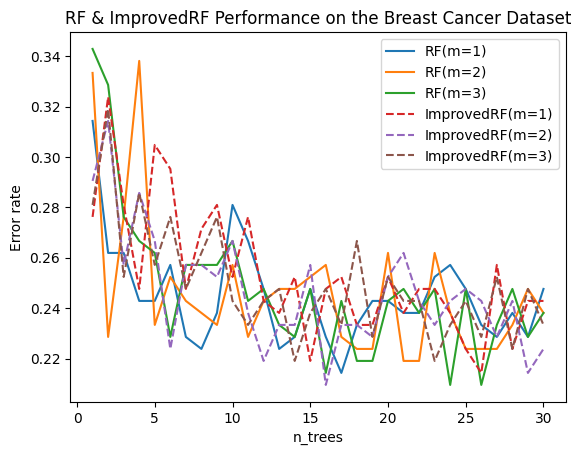

In [7]:
n_trees = np.arange(1, 31)
m_features = [1, 2, 3]
n_exp=3

error_rates = np.load("test_breast_cancer_n30_m.npz")
error_rates_mean = error_rates["mean"]
error_rates_std = error_rates["std"]
for m in m_features:
    plt.plot(n_trees, error_rates_mean[m_features.index(m), :],
             label=f"RF(m={m})")

error_rates = np.load("test_breast_cancer_n30_m_improved.npz")
error_rates_mean = error_rates["mean"]
error_rates_std = error_rates["std"]
for m in m_features:
    plt.plot(n_trees, error_rates_mean[m_features.index(m), :],
             "--", label=f"ImprovedRF(m={m})")

plt.xlabel("n_trees")
plt.ylabel("Error rate")
plt.title("RF & ImprovedRF Performance on the Breast Cancer Dataset")
plt.legend()